In [47]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgbm
from lightgbm import LGBMClassifier

from catboost import CatBoostClassifier

import optuna
from optuna.samplers import TPESampler

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import roc_auc_score

import copy
import os
import pickle
import json
import time

from IPython.display import clear_output
from tqdm.notebook import tqdm

In [43]:
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 500)

# Данные

In [ ]:
df = pd.read_csv('data/df_feats_v2.csv')
train_mask = df.set_type=='train'
test_mask = df.set_type=='test'
feats = np.load('data/feature_list_v2.npy')
cat_feats = []
target = 'target'

In [118]:
len(feats) - len(set(feats))

NameError: name 'feats' is not defined

In [135]:
import numpy  as np
import pandas as pd
bootstrap_frac = 1
seed=1
df = pd.DataFrame({'a':[1,2,3], 'c':[1,22,33],'d':[1,222,333]})
bs = df.sample(frac=bootstrap_frac, replace=True, random_state=seed)
bs


,a,c,d
1,2,22,222
0,1,1,1
0,1,1,1


In [136]:
e = []
e.append(df)
e.append(df)
e.append(df)
e

[   a   c    d
 0  1   1    1
 1  2  22  222
 2  3  33  333,
    a   c    d
 0  1   1    1
 1  2  22  222
 2  3  33  333,
    a   c    d
 0  1   1    1
 1  2  22  222
 2  3  33  333]

In [137]:
df

,a,c,d
0,1,1,1
1,2,22,222
2,3,33,333


In [140]:
for i, fi_df in enumerate(e):
    print(fi_df.columns)
    fi_df.rename(columns={'a': f'a_{i}'},inplace=True)


Index(['a_0', 'c', 'd'], dtype='object')
Index(['a_0', 'c', 'd'], dtype='object')
Index(['a_0', 'c', 'd'], dtype='object')


In [141]:
pd.concat(e,axis=1)

,a_0,c,d,a_0,c,d,a_0,c,d
0,1,1,1,1,1,1,1,1,1
1,2,22,222,2,22,222,2,22,222
2,3,33,333,3,33,333,3,33,333


# Сортировка фичей по среднему feature importance

In [5]:
def build_random_model(df, all_feats, target, seed, use_n_feats=None, bootstrap_frac=1, cat_feats=[], n_jobs=3):
    # Случайный набор фичей
    np.random.seed(seed=seed)
    if use_n_feats is None:
        use_n_feats = len(all_feats)
    feats = np.random.choice(all_feats, use_n_feats, replace=False)
    # Бутстрап
    df_bs = df.sample(frac=bootstrap_frac, replace=True, random_state=seed)
    # Модель
    cat_feats = np.unique(set(feats) & set(cat_feats))

    model = LGBMClassifier(random_state=seed, 
                          n_jobs=n_jobs, 
                          importance_type='gain',
                          verbose=-1)
    model.fit(df_bs[feats], 
              df_bs[target], 
              categorical_feature=cat_feats, 
              )
    imp_df = pd.DataFrame(index=model.feature_name_,
                          data={'Importance':model.feature_importances_})
    return imp_df

In [6]:
fi_lst = []
for seed in tqdm(range(100)):
    imp_df = build_random_model(df=df[train_mask], 
                               all_feats=feats, 
                               target=target, 
                               seed=seed, 
                               use_n_feats=None, 
                               bootstrap_frac=1, 
                               cat_feats=cat_feats)
    fi_lst.append(imp_df)
    time.sleep(10)

  0%|          | 0/100 [00:00<?, ?it/s]

In [7]:
for seed in tqdm(range(101, 400)):
    imp_df = build_random_model(df=df[train_mask],
                               all_feats=feats, 
                               target=target, 
                               seed=seed, 
                               use_n_feats=50, 
                               bootstrap_frac=1, 
                               cat_feats=cat_feats)
    fi_lst.append(imp_df)
    time.sleep(10)

  0%|          | 0/299 [00:00<?, ?it/s]

In [8]:
for i, fi_df in enumerate(fi_lst):
    fi_df.rename(columns={'Importance': f'Importance_{i}'},
                inplace=True)

In [9]:
fi_df_full = pd.concat(fi_lst, axis=1)

In [10]:
fi_df_full['Importance_mean'] = fi_df_full.mean(axis=1)

In [11]:
fi_df_full.sort_values('Importance_mean', ascending=False, inplace=True)

In [12]:
fi_df_full

,Importance_0,Importance_1,Importance_2,Importance_3,Importance_4,Importance_5,Importance_6,Importance_7,Importance_8,Importance_9,...,Importance_390,Importance_391,Importance_392,Importance_393,Importance_394,Importance_395,Importance_396,Importance_397,Importance_398,Importance_mean
employee_count_nm_cd,68.746301,348.970013,286.708008,6461.076039,6612.388227,6546.365674,6570.932166,6237.671019,1174.795396,7463.933496,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4497.947226
employee_count_nm_cd_v2,6918.397511,6284.434659,7290.118297,0.000000,0.000000,0.000000,0.000000,0.000000,4589.318313,0.000000,...,NaN,7884.403819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3622.409210
age_0,2517.385224,2534.297528,2486.628487,2540.869945,2748.360314,3566.083812,3141.675104,2896.765612,4143.681344,2335.688754,...,NaN,NaN,NaN,NaN,NaN,5224.444997,NaN,NaN,NaN,3439.638726
m_4_5_sum_ttl,661.615419,1676.728036,1529.898805,1342.935322,1383.628487,884.482707,985.670801,1046.397707,1507.675808,1245.541759,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2090.025062
cat_51_cnt,366.641598,206.061589,3110.618836,142.014861,3548.067141,169.182250,144.821832,3590.966329,136.124008,135.093239,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2087.586534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cat_37_m_3_6_sum_in,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,21.004809,4.397751
cat_23_m_7_8_sum_in,0.000000,17.011499,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.205700,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.310364
cat_23_m_5_6_sum_in,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,25.991789,NaN,NaN,NaN,NaN,NaN,NaN,3.836682
cat_28_m_7_8_sum_in,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.401419


In [13]:
fi_df_full.to_csv('data/feats_v2_sorted.csv', index='Feature')

In [14]:
feats_sorted = fi_df_full.index.to_list()

# Отбор фичей

In [15]:
model = LGBMClassifier(random_state=0, 
                          n_jobs=3, 
                          verbose=-1)

In [16]:
cross_validate(model, 
               df.loc[train_mask, feats], 
               df.loc[train_mask, target], 
               groups=df.loc[train_mask, 'fold'], 
               cv=5, 
               return_train_score=True,
               scoring='roc_auc')

{'fit_time': array([8.65448904, 8.84377575, 8.43837309, 8.65361142, 8.72893763]),
 'score_time': array([0.13602114, 0.12501049, 0.11302543, 0.12550616, 0.09789658]),
 'test_score': array([0.69194652, 0.73701823, 0.79256478, 0.80349711, 0.75160699]),
 'train_score': array([0.94436893, 0.94229912, 0.94062218, 0.9355627 , 0.94481443])}

In [17]:
def get_metric(model, df, feats, target, fold_col, cv=5):
    res_tmp = cross_validate(model, 
                           df[feats], 
                           df[target], 
                           groups=df[fold_col], 
                           cv=cv, 
                           return_train_score=True,
                           scoring='roc_auc')
    res = {}
    for i in range(cv):
        res[f'train_{i}'] = res_tmp['train_score'][i]
        res[f'test_{i}'] = res_tmp['test_score'][i]
    res['train_mean'] = res_tmp['train_score'].mean()
    res['test_mean'] = res_tmp['test_score'].mean()
    res['train_std'] = res_tmp['train_score'].std()
    res['test_std'] = res_tmp['test_score'].std()
    return res

In [18]:
class SortedFeatureSelection():
    def __init__(self, seed):
        self.seed = seed
        self.res = {}
    
    def count_metrics(self, 
                      df, 
                      target, 
                      fold_col,
                      sorted_feature_list, 
                      categorical_feature, 
                      n_jobs, 
                      name,
                      cv=5,
                     scoring='roc_auc'):
        feats = []
        res = pd.DataFrame()
        for f in tqdm(sorted_feature_list):
            feats.append(f)
            categorical_feature_tmp = sorted(list(set(categorical_feature) & set(feats)))
            model = LGBMClassifier(random_state=self.seed, 
                          n_jobs=n_jobs, 
                          verbose=-1)
            res_tmp = get_metric(model, df, feats, target, fold_col, cv)
            
            res.loc[len(feats), 'n_feats'] = len(feats)
            for k in res_tmp:
                res.loc[len(feats), k] = res_tmp[k]
            res.loc[len(feats), 'feats'] = ' '.join(feats)
        self.res[name] = res
        res.to_csv(f'results/{name}.csv')
        time.sleep(10)

    def get_model(self, method, iter_, train, cat_feats, target, ):
        feats = self.res[method].loc[iter_, 'feats'].split(' ')
        model = LGBMClassifier(random_state=0, 
                              n_jobs=5, 
                              verbose=-1)
        cat_feats_tmp = sorted(list(set(cat_feats) & set(feats)))
        model.fit(train[feats], train[target], categorical_feature=cat_feats_tmp)
        return model

In [19]:
fs = SortedFeatureSelection(seed=0)
fs.count_metrics(df=df[train_mask], 
                 target=target, 
                 fold_col='fold',
                 sorted_feature_list=feats_sorted,
                 categorical_feature=cat_feats, 
                 n_jobs=5, 
                 name='v2')

  0%|          | 0/826 [00:00<?, ?it/s]

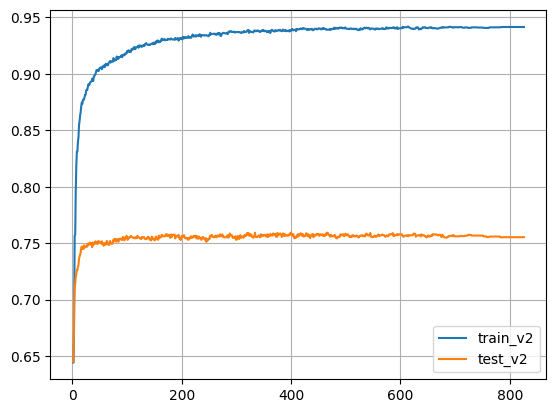

In [21]:
type_ = 'v2'
plt.plot(fs.res[type_].train_mean, label=f'train_{type_}')
plt.plot(fs.res[type_].test_mean, label=f'test_{type_}')

plt.legend()
plt.grid()
plt.show()

In [22]:
fs.res[type_].loc[fs.res[type_].test_mean == fs.res[type_].test_mean.max()]

,n_feats,train_0,test_0,train_1,test_1,train_2,test_2,train_3,test_3,train_4,test_4,train_mean,test_mean,train_std,test_std,feats
400,400.0,0.940737,0.702662,0.938848,0.74814,0.938147,0.789785,0.934093,0.80249,0.939792,0.754155,0.938323,0.759446,0.002289,0.035081,employee_count_nm_cd employee_count_nm_cd_v2 a...


In [23]:
best_feats_str = fs.res[type_].loc[fs.res[type_].test_mean == fs.res[type_].test_mean.max(), 'feats'].iloc[0]
best_feats = best_feats_str.split(' ')

In [24]:
len(best_feats)

400

In [25]:
model = LGBMClassifier(random_state=0, 
                              n_jobs=5, 
                              verbose=-1)
model.fit(df.loc[train_mask, best_feats], df.loc[train_mask, target])

LGBMClassifier(n_jobs=5, random_state=0, verbose=-1)

In [26]:
get_metric(model, df[train_mask], best_feats, target, 'fold', 5)

{'train_0': 0.9407369617520016,
 'test_0': 0.7026619071452004,
 'train_1': 0.9388476613044239,
 'test_1': 0.7481395461180499,
 'train_2': 0.9381468616224431,
 'test_2': 0.7897851225315144,
 'train_3': 0.9340926748875197,
 'test_3': 0.8024896016927052,
 'train_4': 0.9397919049605346,
 'test_4': 0.754154598562032,
 'train_mean': 0.9383232129053847,
 'test_mean': 0.7594461552099004,
 'train_std': 0.0022885295569975038,
 'test_std': 0.03508128285124976}

In [31]:
best_feats_2 = best_feats.copy()
best_feats_2.remove('employee_count_nm_cd_v2')

In [32]:
model = LGBMClassifier(random_state=0, 
                              n_jobs=5, 
                              verbose=-1)
model.fit(df.loc[train_mask, best_feats_2], df.loc[train_mask, target])

LGBMClassifier(n_jobs=5, random_state=0, verbose=-1)

In [33]:
get_metric(model, df[train_mask], best_feats_2, target, 'fold', 5)

{'train_0': 0.9407369617520016,
 'test_0': 0.7026619071452004,
 'train_1': 0.9388476613044239,
 'test_1': 0.7481395461180499,
 'train_2': 0.9381468616224431,
 'test_2': 0.7897851225315144,
 'train_3': 0.9340926748875197,
 'test_3': 0.8024896016927052,
 'train_4': 0.9397919049605346,
 'test_4': 0.754154598562032,
 'train_mean': 0.9383232129053847,
 'test_mean': 0.7594461552099004,
 'train_std': 0.0022885295569975038,
 'test_std': 0.03508128285124976}

In [34]:
best_feats.remove('employee_count_nm_cd_v2')

# Optuna

In [35]:
optuna.logging.disable_default_handler()

In [37]:
class OptunaOptimizator():
    def __init__(self, 
                 df, 
                 feats, 
                 cat_feats,
                 target, 
                 params, 
                 metric_func, 
                 metirc_value_func,
                 metric_mode, 
                 feature_selection_mode,
                 fold_col,
                 include_lim=0.5,
                 metric_func_params={}
                ):
        self.params = params
        self.params_lst = list(params.keys())
        self.metric_func = metric_func
        self.metirc_value_func = metirc_value_func
        self.df = df
        self.target = target
        self.feats = feats
        self.cat_feats = cat_feats
        self.metric_mode = metric_mode
        self.feature_selection_mode = feature_selection_mode
        self.include_lim = include_lim
        self.metric_func_params = metric_func_params
        self.optuna_log = pd.DataFrame()
        self.trial_id = 0
        self.best_model = None
        self.best_value = -999
        self.fold_col = fold_col

    def objective(self, trial):
        model_params = {}
        for p in self.params:
            tmp = self.params[p]
            if tmp[0] == 'int':
                model_params[p] = trial.suggest_int(p, tmp[1], tmp[2])
            elif tmp[0] == 'float':
                if len(tmp)==3:
                    model_params[p] = trial.suggest_float(p, tmp[1], tmp[2])
                elif len(tmp)==4:
                    model_params[p] = trial.suggest_int(p, tmp[1], tmp[2], tmp[3])
            elif tmp[0] == 'categorical' or tmp[0] == 'cat':
                model_params[p] = trial.suggest_categorical(p, tmp[1])
            elif tmp[0] == 'fixed':
                model_params[p] = tmp[1]
        if self.feature_selection_mode == 'none':
            feats = self.feats
        elif self.feature_selection_mode == 'fit_every':
            feats = []
            for f in self.feats:
                p = trial.suggest_float(f'use_{f}', 0, 1)
                if p >= self.include_lim:
                    feats.append(f)
        elif self.feature_selection_mode == 'fit_n':
            n = trial.suggest_int('n_feats', 3, len(self.feats))
            feats = feats[:n]
        
        # try:
        metric, value = self.build_model(model_params, feats)
        # except:
        #     metric = {}
        #     value=None
        self.optuna_log.loc[self.trial_id, 'value'] = value
        for m in metric:
            self.optuna_log.loc[self.trial_id, m] = metric[m]
        for p in model_params:
            self.optuna_log.loc[self.trial_id, p] = model_params[p]
        if self.feature_selection_mode != 'none':
            for f in self.feats:
                self.optuna_log.loc[self.trial_id, f] = int(f in feats)
        return value

    def build_model(self, params, feats):
        # cat_feats = sorted(list(set(self.cat_feats) & set(feats)))
        model = LGBMClassifier(**params)
        metric = self.metric_func(model=model, df=self.df, feats=feats, target=target, fold_col=self.fold_col)
        value = self.metirc_value_func(metric)
        if value > self.best_value:
            self.best_model = LGBMClassifier(**params)
            self.best_model.fit(self.df[feats], self.df[self.target], categorical_feature=cat_feats)
        return metric, value

    def fit(self, seed, n_trials, n_startup_trials, log_path='optuna_log.csv'):
        self.study = optuna.create_study(sampler=TPESampler(seed=seed, n_startup_trials=n_startup_trials), 
                                    direction='maximize')
        for self.trial_id in range(n_trials):
            self.study.optimize(self.objective, n_trials=1)
            clear_output()
            display(self.optuna_log.iloc[[-1]])
            if self.trial_id % 100 == 0:
                self.optuna_log.to_csv(log_path, index=False)
            time.sleep(10)

In [38]:
opt_params = {}
opt_params['max_depth'] = ['int', 3, 5]
opt_params['learning_rate'] = ['float',  0.001, 0.2]
opt_params['n_estimators'] = ['int', 100, 500, 50]
opt_params['reg_alpha'] = ['float', 0, 3]
opt_params['reg_lambda'] = ['float', 0, 3]
opt_params['boosting_type'] = ['categorical', ['gbdt', 'dart']]

# fixed
opt_params['verbose'] = ['fixed', -1]
opt_params['random_state'] = ['fixed', 1]
opt_params['n_jobs'] = ['fixed', 10]

In [39]:
def metirc_value_func(metric):
    return metric['test_mean']

In [40]:
oo = OptunaOptimizator(df=df[train_mask],
                       feats=best_feats,
                       cat_feats=cat_feats,
                       target=target,
                       params=opt_params,
                       metric_func=get_metric,
                       metirc_value_func=metirc_value_func,
                       metric_mode='cv', 
                       feature_selection_mode='none',
                       fold_col='fold')

In [41]:
oo.fit(seed=0, 
       n_trials=3000, 
       n_startup_trials=150, 
       log_path='log/optuna_1_log.csv')

,value,train_0,test_0,train_1,test_1,train_2,test_2,train_3,test_3,train_4,...,test_std,max_depth,learning_rate,n_estimators,reg_alpha,reg_lambda,boosting_type,verbose,random_state,n_jobs
511,0.76329,0.796197,0.697953,0.781781,0.767232,0.767261,0.79993,0.769518,0.810208,0.790679,...,0.040791,3.0,0.010494,418.0,1.494134,2.920037,gbdt,-1.0,1.0,10.0


Trial 512 failed with parameters: {'max_depth': 3, 'learning_rate': 0.04031496287953303, 'n_estimators': 404, 'reg_alpha': 1.3667011360375017, 'reg_lambda': 2.7337964903094583, 'boosting_type': 'gbdt'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\gzoni\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\gzoni\AppData\Local\Temp\ipykernel_16580\1527790573.py", line 62, in objective
    metric, value = self.build_model(model_params, feats)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gzoni\AppData\Local\Temp\ipykernel_16580\1527790573.py", line 83, in build_model
    self.best_model.fit(self.df[feats], self.df[self.target], categorical_feature=cat_feats)
  File "C:\Users\gzoni\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\sklearn.py", lin

KeyboardInterrupt: 

In [44]:
oo.optuna_log.sort_values('value', ascending=False)

,value,train_0,test_0,train_1,test_1,train_2,test_2,train_3,test_3,train_4,test_4,train_mean,test_mean,train_std,test_std,max_depth,learning_rate,n_estimators,reg_alpha,reg_lambda,boosting_type,verbose,random_state,n_jobs
450,0.769367,0.830158,0.716464,0.819898,0.759714,0.807987,0.802814,0.806931,0.812083,0.825823,0.755761,0.818159,0.769367,0.009330,0.034700,3.0,0.037150,363.0,1.313510,2.992499,gbdt,-1.0,1.0,10.0
190,0.769268,0.833283,0.717788,0.822904,0.759007,0.812045,0.801784,0.810510,0.812126,0.828910,0.755636,0.821530,0.769268,0.009010,0.034163,3.0,0.035752,403.0,1.286156,2.711753,gbdt,-1.0,1.0,10.0
309,0.769254,0.832245,0.717099,0.822949,0.759345,0.811793,0.801522,0.810328,0.811501,0.828584,0.756801,0.821180,0.769254,0.008789,0.034057,3.0,0.034353,421.0,1.468195,2.761545,gbdt,-1.0,1.0,10.0
357,0.769219,0.827073,0.716214,0.816557,0.760250,0.805140,0.802564,0.803871,0.811946,0.822871,0.755121,0.815103,0.769219,0.009286,0.034717,3.0,0.030527,402.0,1.476266,2.514879,gbdt,-1.0,1.0,10.0
411,0.769177,0.833220,0.717107,0.822999,0.758225,0.811832,0.802139,0.810280,0.811452,0.829099,0.756960,0.821486,0.769177,0.009129,0.034218,3.0,0.035406,409.0,1.656614,2.619006,gbdt,-1.0,1.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,0.732765,0.999663,0.684099,0.999503,0.720225,0.999439,0.755373,0.999611,0.759405,0.999640,0.744722,0.999571,0.732765,0.000086,0.027890,5.0,0.195269,456.0,2.293686,2.094745,gbdt,-1.0,1.0,10.0
2,0.732044,0.754616,0.660305,0.729054,0.734923,0.716518,0.764576,0.723488,0.782101,0.745547,0.718312,0.733845,0.732044,0.014134,0.042208,3.0,0.018339,108.0,2.497860,2.334470,dart,-1.0,1.0,10.0
68,0.728142,0.999914,0.674194,0.999928,0.716181,0.999914,0.742091,0.999911,0.763098,0.999967,0.745147,0.999927,0.728142,0.000021,0.030851,5.0,0.193625,498.0,1.355465,0.212609,gbdt,-1.0,1.0,10.0
108,0.726244,0.757101,0.655593,0.733640,0.724574,0.718644,0.745899,0.725618,0.784015,0.751486,0.721139,0.737298,0.726244,0.014773,0.041819,4.0,0.001275,199.0,0.954701,2.576332,gbdt,-1.0,1.0,10.0


In [96]:
params = dict(oo.optuna_log.sort_values('value', ascending=False).iloc[0, 15:])
params['verbose'] = int(params['verbose'])
params['random_state'] = int(params['random_state'])
params['n_estimators'] = int(params['n_estimators'])
params['n_jobs'] = int(params['n_jobs'])
params['max_depth'] = int(params['max_depth'])



model = LGBMClassifier(**params)
model.fit(df.loc[train_mask, best_feats], df.loc[train_mask, target])

LGBMClassifier(learning_rate=0.03715043124211706, max_depth=3, n_estimators=363,
               n_jobs=10, random_state=1, reg_alpha=1.313509570723126,
               reg_lambda=2.9924993981757786, verbose=-1)

In [98]:
df['predict'] = model.predict_proba(df[best_feats])[:,1]

In [99]:
with open('models/model_2.pkl', 'wb') as f:
    pickle.dump(model, f)

In [100]:
df.loc[test_mask, ['user_id', 'predict']].to_csv('results/result_2.csv', index=False)

In [ ]:
oo.best_model

In [170]:
imp_df = pd.DataFrame(index=oo.best_model.feature_name_,
                          data={'Importance':oo.best_model.feature_importances_}).sort_values('Importance', ascending=False)

<Axes: >

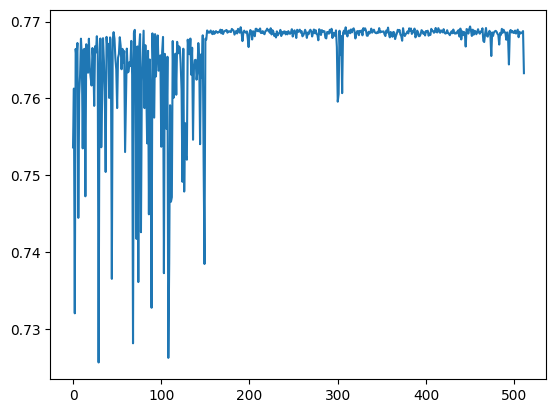

In [59]:
oo.optuna_log.value.plot()

# Optuna с catboost

In [72]:
class OptunaOptimizator_ctb():
    def __init__(self, 
                 df, 
                 feats, 
                 cat_feats,
                 target, 
                 params, 
                 metric_func, 
                 metirc_value_func,
                 metric_mode, 
                 feature_selection_mode,
                 fold_col,
                 include_lim=0.5,
                 metric_func_params={}
                ):
        self.params = params
        self.params_lst = list(params.keys())
        self.metric_func = metric_func
        self.metirc_value_func = metirc_value_func
        self.df = df
        self.target = target
        self.feats = feats
        self.cat_feats = cat_feats
        self.metric_mode = metric_mode
        self.feature_selection_mode = feature_selection_mode
        self.include_lim = include_lim
        self.metric_func_params = metric_func_params
        self.optuna_log = pd.DataFrame()
        self.trial_id = 0
        self.best_model = None
        self.best_value = -999
        self.fold_col = fold_col

    def objective(self, trial):
        model_params = {}
        for p in self.params:
            tmp = self.params[p]
            if tmp[0] == 'int':
                model_params[p] = trial.suggest_int(p, tmp[1], tmp[2])
            elif tmp[0] == 'float':
                if len(tmp)==3:
                    model_params[p] = trial.suggest_float(p, tmp[1], tmp[2])
                elif len(tmp)==4:
                    model_params[p] = trial.suggest_int(p, tmp[1], tmp[2], tmp[3])
            elif tmp[0] == 'categorical' or tmp[0] == 'cat':
                model_params[p] = trial.suggest_categorical(p, tmp[1])
            elif tmp[0] == 'fixed':
                model_params[p] = tmp[1]
        if self.feature_selection_mode == 'none':
            feats = self.feats
        elif self.feature_selection_mode == 'fit_every':
            feats = []
            for f in self.feats:
                p = trial.suggest_float(f'use_{f}', 0, 1)
                if p >= self.include_lim:
                    feats.append(f)
        elif self.feature_selection_mode == 'fit_n':
            n = trial.suggest_int('n_feats', 3, len(self.feats))
            feats = feats[:n]
        
        # try:
        metric, value = self.build_model(model_params, feats)
        # except:
        #     metric = {}
        #     value=None
        self.optuna_log.loc[self.trial_id, 'value'] = value
        for m in metric:
            self.optuna_log.loc[self.trial_id, m] = metric[m]
        for p in model_params:
            self.optuna_log.loc[self.trial_id, p] = model_params[p]
        if self.feature_selection_mode != 'none':
            for f in self.feats:
                self.optuna_log.loc[self.trial_id, f] = int(f in feats)
        return value

    def build_model(self, params, feats):
        # cat_feats = sorted(list(set(self.cat_feats) & set(feats)))
        model = CatBoostClassifier(**params)
        metric = self.metric_func(model=model, df=self.df, feats=feats, target=target, fold_col=self.fold_col)
        value = self.metirc_value_func(metric)
        if value > self.best_value:
            self.best_model = CatBoostClassifier(**params)
            self.best_model.fit(self.df[feats], self.df[self.target], cat_features=cat_feats)
        return metric, value

    def fit(self, seed, n_trials, n_startup_trials, log_path='optuna_log.csv'):
        self.study = optuna.create_study(sampler=TPESampler(seed=seed, n_startup_trials=n_startup_trials), 
                                    direction='maximize')
        for self.trial_id in range(n_trials):
            self.study.optimize(self.objective, n_trials=1)
            clear_output()
            display(self.optuna_log.iloc[[-1]])
            if self.trial_id % 100 == 0:
                self.optuna_log.to_csv(log_path, index=False)
            time.sleep(10)

In [73]:
opt_params = {}
opt_params['depth'] = ['int', 3, 4]
opt_params['learning_rate'] = ['float',  0.001, 0.2]
opt_params['n_estimators'] = ['int', 100, 500, 50]
opt_params['rsm'] = ['float', 0, 1] 
opt_params['l2_leaf_reg'] = ['float', 0, 5] 
opt_params['auto_class_weights'] = ['categorical', [None, 'Balanced', 'SqrtBalanced']]

# fixed
opt_params['verbose'] = ['fixed', False] #?
opt_params['random_seed'] = ['fixed', 1]
opt_params['thread_count'] = ['fixed', 10]
# opt_params['task_type'] = ['fixed', 'GPU']
# opt_params['devices'] = ['fixed', '0']


In [74]:
def metirc_value_func(metric):
    return metric['test_mean']

In [75]:
oo_2 = OptunaOptimizator_ctb(df=df[train_mask],
                       feats=best_feats,
                       cat_feats=cat_feats,
                       target=target,
                       params=opt_params,
                       metric_func=get_metric,
                       metirc_value_func=metirc_value_func,
                       metric_mode='cv', 
                       feature_selection_mode='none',
                       fold_col='fold')

In [76]:
oo_2.fit(seed=0, 
       n_trials=80, 
       n_startup_trials=50, 
       log_path='log/optuna_3_log.csv')

,value,train_0,test_0,train_1,test_1,train_2,test_2,train_3,test_3,train_4,test_4,train_mean,test_mean,train_std,test_std,depth,learning_rate,n_estimators,rsm,l2_leaf_reg,auto_class_weights,verbose,random_seed,thread_count
79,0.771042,0.843612,0.718254,0.833178,0.759107,0.822492,0.803881,0.823009,0.813119,0.839416,0.760849,0.832341,0.771042,0.008507,0.034298,3.0,0.107494,419.0,0.48631,4.513317,SqrtBalanced,False,1.0,10.0


In [77]:
oo_2.optuna_log.sort_values('value', ascending=False)

,value,train_0,test_0,train_1,test_1,train_2,test_2,train_3,test_3,train_4,test_4,train_mean,test_mean,train_std,test_std,depth,learning_rate,n_estimators,rsm,l2_leaf_reg,auto_class_weights,verbose,random_seed,thread_count
56,0.772400,0.824609,0.716832,0.811045,0.760759,0.799169,0.807338,0.798510,0.819733,0.818344,0.757338,0.810335,0.772400,0.010324,0.037179,3.0,0.064567,458.0,0.361763,4.990210,SqrtBalanced,False,1.0,10.0
78,0.771900,0.820116,0.718226,0.805935,0.758647,0.794103,0.808056,0.793689,0.817955,0.813076,0.756614,0.805384,0.771900,0.010397,0.036657,3.0,0.060064,432.0,0.489421,4.464474,SqrtBalanced,False,1.0,10.0
75,0.771850,0.820419,0.716795,0.806742,0.760117,0.795221,0.807673,0.794547,0.818340,0.814427,0.756327,0.806271,0.771850,0.010261,0.037025,3.0,0.056829,477.0,0.335073,4.714738,SqrtBalanced,False,1.0,10.0
52,0.771687,0.818223,0.716532,0.804443,0.757820,0.792818,0.807137,0.792659,0.820208,0.812531,0.756735,0.804135,0.771687,0.010284,0.037600,3.0,0.057109,451.0,0.357405,4.979857,SqrtBalanced,False,1.0,10.0
53,0.771653,0.821688,0.716474,0.809204,0.758254,0.797141,0.808062,0.796569,0.819789,0.816879,0.755688,0.808296,0.771653,0.010157,0.037741,3.0,0.061832,454.0,0.369233,4.972727,SqrtBalanced,False,1.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,0.754747,0.920398,0.707049,0.915907,0.735408,0.915211,0.778408,0.912586,0.793046,0.919455,0.759823,0.916711,0.754747,0.002865,0.030665,4.0,0.179438,497.0,0.216897,3.315391,SqrtBalanced,False,1.0,10.0
38,0.754444,0.776866,0.696202,0.755689,0.749727,0.742300,0.796008,0.744279,0.805316,0.770142,0.724964,0.757855,0.754444,0.013736,0.041470,3.0,0.047215,153.0,0.053427,3.627972,Balanced,False,1.0,10.0
40,0.752361,0.767706,0.684493,0.744101,0.757834,0.728505,0.794319,0.733752,0.802490,0.757258,0.722671,0.746264,0.752361,0.014541,0.044251,3.0,0.027165,122.0,0.301599,1.310591,SqrtBalanced,False,1.0,10.0
29,0.743107,0.758066,0.669325,0.730926,0.748432,0.718578,0.785636,0.723993,0.795954,0.747449,0.716189,0.735802,0.743107,0.014773,0.046472,4.0,0.006107,183.0,0.424685,1.870850,SqrtBalanced,False,1.0,10.0


<Axes: >

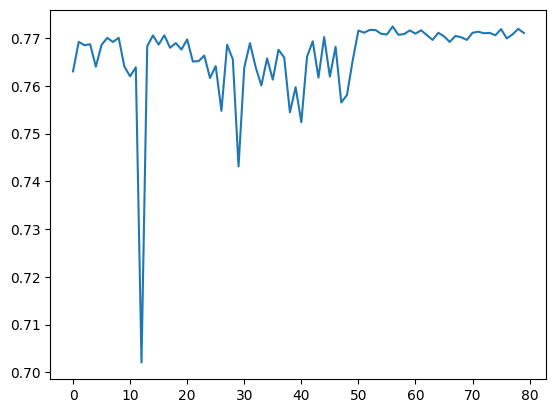

In [78]:
oo_2.optuna_log.value.plot()

In [79]:
def get_ppi(h, w, d):
    return np.sqrt(w**2 + h**2)/d

In [80]:
get_ppi(3840, 2160, 75)

58.74419120219462

In [101]:
params = dict(oo_2.optuna_log.sort_values('value', ascending=False).iloc[0, 15:])
# params['verbose'] = int(params['verbose'])
# params['random_state'] = int(params['random_state'])
# params['n_estimators'] = int(params['n_estimators'])
# params['n_jobs'] = int(params['n_jobs'])
# params['max_depth'] = int(params['max_depth'])



model = CatBoostClassifier(**params)
model.fit(df.loc[train_mask, best_feats], df.loc[train_mask, target])

In [102]:
params

{'depth': 3.0,
 'learning_rate': 0.06456724362910535,
 'n_estimators': 458.0,
 'rsm': 0.3617626928959776,
 'l2_leaf_reg': 4.990210215239965,
 'auto_class_weights': 'SqrtBalanced',
 'verbose': False,
 'random_seed': 1.0,
 'thread_count': 10.0}

In [103]:
df['predict'] = model.predict_proba(df[best_feats])[:,1]

In [104]:
with open('models/model_3.pkl', 'wb') as f:
    pickle.dump(model, f)

In [105]:
df.loc[test_mask, ['user_id', 'predict']].to_csv('results/result_3.csv', index=False)

In [3]:
import pandas as pd
d = pd.DataFrame()
d.loc[0,'a'] = 0

In [4]:
d

,a
0,0.0
